## Loss distribution of a loan portfolio under the Vasicek model

## Introduction
Having a substantial dataset of defaulted loans and a proper model to explain the loss distribution is vital in order to quantify the credit risk which the lending facility is potentially exposed to in a certain period. In the banking sector, under the *Basel accords* regulatory framework, credit risk metrics establish the minimal capital requirements the lender should hold as a safety net in case a relevant fraction of borrowers won't honor their obligations. We'll simulate the loss distribution of risky loans using the *Vasicek one-factor model* as data generator. Although simple, we'll see that the model produces a fairly realistic loss distribution.  
As an interesting future development, a similar analysis could be performed wrt the claims distribution in the insurance realms.

## Expected and unexpected losses
Consider a portfolio consisting of *n* loans. The expected loss (EL) of the portfolio over a predefined time span can be estimated as: 
$$
EL = PD_i * EAD_i * LGD_i
$$
where
 - $PD_i$ is the probability of default of the i-th loan (estimated from historical data) in a certain time period, such as 1 year.
 - $EAD_i$ is the Exposure At Default of the i-th loan, i.e. the nominal monetary value of the loan we put at risk.
 - $LGD_i$ is the Loss Given Default of the i-th loan: this is the percentage of the loan amount (EAD) that's actually lost, provided that some portion could be recovered from sources such as the ex-ante collateral forced to the borrower. The LGD also (or conversely, the *recovery rate*) is estimated from historical data.
 
EL provides a measure of the average loss the lender "takes for granted" on the typical period (typically one year) and therefore accounts directly as provision or charges as a spread cost (or fee, or "margin") to the loan borrower... but life is a bumpy ride, hence banks should also guard against *\"Unexpected Losses\" (UL)*. This amount, under the Basel II accord, is formally defined as a specific loss percentile (99.9%) netted by the EL, i.e.

$$
UL = VaR_{99.9\%} - EL
$$

as such, this measure reflect the extent to which EL may be exceeded in extreme scenarios for a given period and a given confidence interval, and is sometimes referred to as *credit VaR*.  
The aforementioned metrics are inferred from the distribution of portfolio losses, which we are going to reproduce through the Vasicek model.

## The Vasicek model
The *Vasicek model* (1987) is practically relevant, as it's exploited by the *Basel II Internal Rating-Based(IRB)* regulatory framework to describe the yearly default rate of a loan portfolio. An important aspect of the model is that it treats the loan defaulting probability as the concurrence of two causes: the *systematic risk* of the economy as a whole (or perhaps the sector in which a class of borrowers operate) and the *specific risk* of the single borrower considered in isolation from all the other "peers", so ascribable to its intrinsic peculiarities (in case of a firm it could represent the state of its internal processes, business strategy and so on). Note that the former risk implies therefore a correlation among the different loans.  
The model relates the default probability of a single loan to a stochastic variable $X_i$ given by:

$$
X_i = \sqrt{\rho} * Z + \sqrt{1 - \rho} * \phi_i
$$

where:
   - $\rho$ is the default correlation among all the borrowers driven by the economy, and represents therefore the impact of the *systematic risk*.
   - $Z$ is a random variable from a standard normal distribution, and it's drawn once for all the loans in the portfolio since it represent a macroscopic state of the overall "reference market".
   - $\phi_i$ is a random standard normal variable, and it's drawn for each particular loan.  

The *i*-th loan is then considered a default if $X_i$ is less than a credit threshold: $X_i < C_{thr}$.

## Simulation
Let's start with a single borrower. We assume that his probability of default (which normally is estimated through historical data) should be *5%*; from this value we infer the credit threshold for our simulation.
### Single borrower

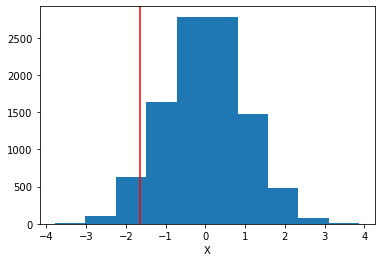

In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm

# probability of default of this single loan
PD = 0.05

# number of simulations
n = 10000

# credit threshold inferred from default probability
thr = norm.ppf(PD)

# strenght of the "economy", i.e. correlation among borrowers operating in the same "market"
rho = 0.1

# random realizations for the "economy", std normal variates
Z = np.random.normal(size=n)

# random realizations of the borrower "instrinsic/idiosyncratic" risk
phi = np.random.normal(size=n)

X = sqrt(rho) * Z + sqrt(1 - rho) * phi

#consistency checks
num_defaults = np.count_nonzero(X < thr)
assert(abs(num_defaults/n - PD) < 0.01)
assert(abs(np.std(X) - 1.0) < 0.05)

ax = plt.subplot()
ax.hist(X);
ax.set_xlabel('X');
ax.axvline(thr, color='red', label='Credit threshold');


Nothing interesting so far...the sum of two normal variables is still a normal variable. Let's see what happens when we consider a pool of different borrowers each one having his own PD, LGD and EAD, and sharing a common "economy".  

### Portfolio of loans
Be $N$ the number of loans in the portfolio. The *i-th* borrower has its own $PD_i$, $LGD_i$ (which are tipically desumed from historical data) and $EAD_i$. We assume that the $PD_i$ are drawn from a right skewed beta distribution (recall that beta is suited for variables ranging from 0 to 1). The $LGD_i$ can also be modelled by a beta distribution, since $LGD_i = 1 - R_i$ where $R_i$ is the recovery rate, and the latter is usually compared against a beta distribution as well; the rationale and validity of these assumptions is not discussed here, but could be found in literature. At last, to simplify things and give the same *a priori* weight to each borrower, we assume that all the $EAD_i$ are equal: this could be the case when the exposure towards the borrowers is pinned to a fixed amount.

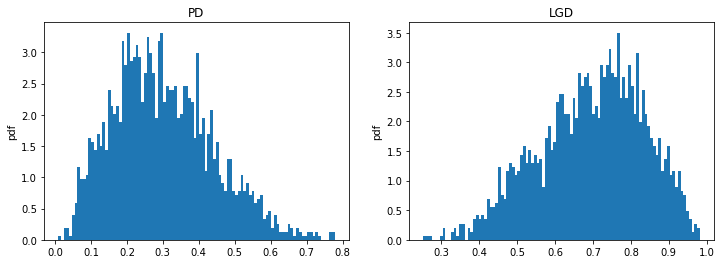

In [3]:
from scipy.stats import beta

# number of outstanding loans in the portfolio
N = 2000

# right skewed
PD = np.random.beta(3, 7, N)
cred_thresholds = norm.ppf(PD)

# left skewed
LGD = np.random.beta(7, 3, N)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4));
ax1.hist(PD, bins=100, density=True);
ax2.hist(LGD, bins=100, density=True);
ax1.set_title('PD')
ax1.set_ylabel('pdf')
ax2.set_title('LGD')
ax2.set_ylabel('pdf')

# To simulate different borrowers exposures we could also arbitrarily draw
# the $EAD_i$ from a (lognormal, gamma ecc.) distribution
EAD_val = 100
EAD = np.ones(N) * EAD_val;

# Number of simulations
nSim = 100000

# The state of the "economy": common to each loan in a given simulated economy scenario
Z = np.random.normal(size=nSim)

# The contingency for the N loans, for each simulated economy scenario
phi = np.random.normal(size=(nSim, N))

# correlation among different loans
rho = 0.2

portfolio_loss = np.zeros(nSim)

for i in range(nSim):
    X = sqrt(rho) * Z[i] + sqrt(1-rho) * phi[i]
    portfolio_loss[i] = np.dot(np.array((X < cred_thresholds)) * EAD, LGD)


(0.2830185253009214, -29993.72242146098, 69048.58799878418)


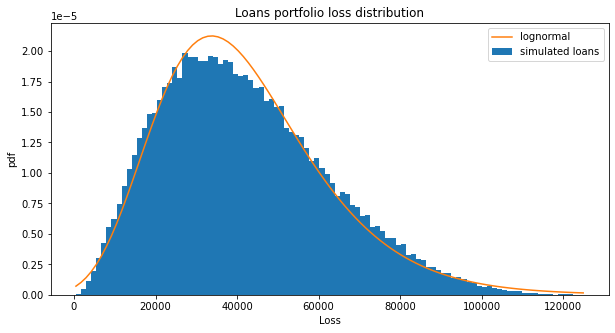

In [10]:
from scipy.stats import lognorm
fig, ax = plt.subplots(1, figsize=(10,5));
_, xbins, _ = ax.hist(portfolio_loss, bins=100, density=True, label='simulated loans');
ax.set_title('Loans portfolio loss distribution');
ax.set_xlabel('Loss');
ax.set_ylabel('pdf');

# fit to a lognormal distribution, which is a typical description statistics
# for these skewed credit loss data
params = lognorm.fit(portfolio_loss)
fitted_distr = lognorm.pdf(xbins, *params);
print(params)
ax.plot(xbins, fitted_distr, label='lognormal');
ax.legend();